# Bitcoin LSTM

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import pickle

# lets import some data

In [31]:
data = pd.read_csv('/Users/kyleevans-lee/proj/notebooks/crypto/Binance_BTCUSDT_minute.csv')[30:]
# data = data.drop(columns=['Unnamed: 0'])
data.index = data.date
data = data.drop(columns=['date'])
data = data[data.index >'2021-05-20']
data =data.drop(columns=['symbol'])
data=data.drop(columns=['Unnamed: 0'])




In [32]:
data_cols = data.columns
data = data[['open', 'high', 'low', 'close', 'tradecount', 'high30min']]
target_col_index = 5

In [33]:
# important numbers
memory_len = 10 # how many blocks back are we looking
target_col_index = 5
future_window=30 # in minutes

# making rolling data
data = data[(pd.DataFrame(range(data.shape[0]))[0]%future_window==0).values]

In [34]:
# this is to add a rolling window to the data
# adding 30 min rolling window
# data = pd.read_csv('/Users/kyleevans-lee/proj/notebooks/crypto/Binance_BTCUSDT_minute.csv')
# min30=[0]*30
# for i in range(30,data.shape[0]):
#     min30.append(max(data.high[i-future_window:i]))
# data['high30min'] = min30
# data.to_csv('/Users/kyleevans-lee/proj/notebooks/crypto/Binance_BTCUSDT_minute.csv')

# normalize


In [35]:
training_data = data[data.index< '2021-08-25'].copy()
test_data = data[data.index> '2021-06-25'].copy()

#training_data =training_data.drop(['unix'], axis = 1)
training_data.index = range(training_data.shape[0])

#test_data =test_data.drop(['unix'], axis = 1)
test_data.index = range(test_data.shape[0])

test_df=test_data.copy()
training_df=training_data.copy()

scaler = MinMaxScaler()
training_data = scaler.fit_transform(training_data)



Batching for the LSTM 

In [36]:
X_train = [] 
Y_train = []
print(training_data.shape)
for i in range(memory_len, training_data.shape[0]):
    X_train.append(training_data[i-memory_len:i])
    Y_train.append(training_data[i,target_col_index])
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_train.shape

(2313, 6)


(2303, 10, 6)

# Initialize the RNN and make architecture

In [37]:
model = Sequential() 
model.add(LSTM(units = 50, activation = 'relu', return_sequences = True, 
               input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2)) 
model.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
model.add(Dropout(0.3)) 
model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
model.add(Dropout(0.4)) 
model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.5)) 
model.add(Dense(units =1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 10, 50)            11400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 50)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 10, 60)            26640     
_________________________________________________________________
dropout_5 (Dropout)          (None, 10, 60)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 10, 80)            45120     
_________________________________________________________________
dropout_6 (Dropout)          (None, 10, 80)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 120)              

In [40]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
history= model.fit(X_train, Y_train, epochs = 15, batch_size =50, validation_split=0.1)

Epoch 1/15
42/42 [==============================] - 7s 55ms/step - loss: 0.0049 - val_loss: 0.0173
Epoch 2/15
42/42 [==============================] - 1s 32ms/step - loss: 0.0042 - val_loss: 0.0155
Epoch 3/15
42/42 [==============================] - 1s 31ms/step - loss: 0.0042 - val_loss: 0.0286
Epoch 4/15
42/42 [==============================] - 1s 31ms/step - loss: 0.0042 - val_loss: 0.0106
Epoch 5/15
42/42 [==============================] - 1s 32ms/step - loss: 0.0041 - val_loss: 0.0227
Epoch 6/15
42/42 [==============================] - 1s 33ms/step - loss: 0.0038 - val_loss: 0.0195
Epoch 7/15
42/42 [==============================] - 1s 33ms/step - loss: 0.0037 - val_loss: 0.0200
Epoch 8/15
42/42 [==============================] - 1s 32ms/step - loss: 0.0037 - val_loss: 0.0222
Epoch 9/15
42/42 [==============================] - 1s 35ms/step - loss: 0.0036 - val_loss: 0.0183
Epoch 10/15
42/42 [==============================] - 2s 43ms/step - loss: 0.0033 - val_loss: 0.0221
Epoch 11/

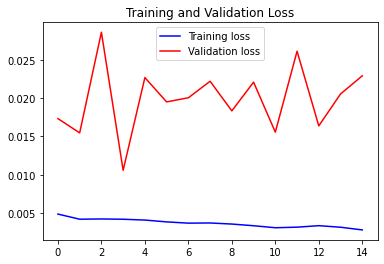

In [41]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [42]:
model.save('../models/lstm10_hour_5featuresv2')
pickle.dump(scaler,open('../models/lstm10_hour_5featuresv2_scaler.pkl','wb')) 


INFO:tensorflow:Assets written to: ../models/lstm10_hour_5featuresv2/assets


# Now lets test the model

Format the test data

In [43]:
test_data.index = range(test_data.shape[0])
test_data = data[data.index> '2021-06-25'].copy()
#test_data =test_data.drop(['unix'], axis = 1)
test_data.index = range(test_data.shape[0])

test_df = test_data.copy()
test_data = scaler.transform(test_data)
test_data

array([[0.35626691, 0.35577146, 0.3680487 , 0.36342182, 0.01142096,
        0.35063918],
       [0.36398921, 0.36280956, 0.37590783, 0.36991953, 0.00342629,
        0.32969642],
       [0.36421237, 0.36248233, 0.37510138, 0.36930628, 0.00571048,
        0.33276489],
       ...,
       [0.39164219, 0.39656584, 0.40278075, 0.40237707, 0.05434472,
        0.37412492],
       [0.43705896, 0.43515539, 0.44202711, 0.43656245, 0.03943403,
        0.40540788],
       [0.42468912, 0.42490195, 0.43459698, 0.43205648, 0.02712477,
        0.42260257]])

format the test data

In [44]:
X_test = []
Y_test = []
inputs = test_data.copy()
#inputs = training_data.copy()
for i in range (60, inputs.shape[0]):
    X_test.append(inputs[i-memory_len:i]) 
    Y_test.append(inputs[i,target_col_index ])
X_test, Y_test = np.array(X_test), np.array(Y_test) 
print(X_test.shape, Y_test.shape)
test_df=test_df.iloc[60:]


(661, 10, 6) (661,)


Scale the test data and predictions back to $

In [45]:
Y_test1 = scaler.inverse_transform(inputs[60:])[:,5]
Y_pred = model.predict(X_test)
Y_pred1=scaler.inverse_transform([list(np.append([0]*5,x)) for x in Y_pred])[:,5]



Test if we are good at predicting just ups 

In [48]:
actual_up= np.array(Y_test1[:1]<Y_test1[1:])
pred_up = np.array(Y_test1[:1]<Y_pred1[1:])

# test_up= np.array(Y_test[:1]<Y_test[1:])
# pred_up = np.array(Y_pred1[:1]<Y_pred1[1:])

In [49]:
count =0
for i,j in zip(actual_up,pred_up):
    if i==j:
        count +=1
count/(len(actual_up)-1)
actual_up.sum()/len(pred_up)

0.9590288315629742

0.8696969696969697

In [ ]:
# Y_pred=model.predict(X_test[:1000])
# scale = scaler.scale_[0]
# Y_test1 = Y_test[-1000:]*1/scale+scaler.data_min_[0]
# Y_test1
#Y_pred1 = Y_pred-scaler.max_[0]#*1/scale+scaler.data_min_[0]


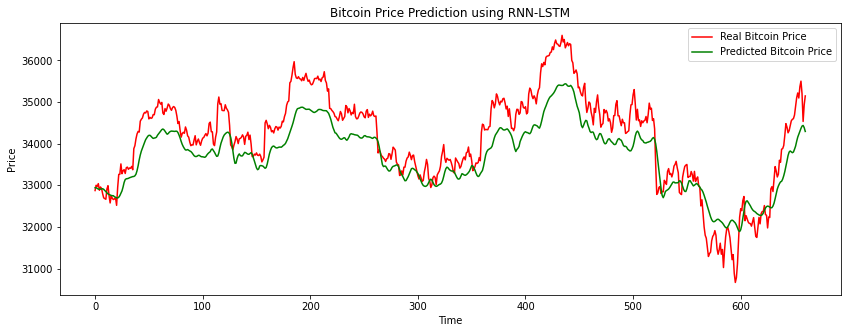

In [50]:
plt.figure(figsize=(14,5))
plt.plot(Y_test1, color = 'red', label = 'Real Bitcoin Price')
plt.plot(Y_pred1, color = 'green', label = 'Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction using RNN-LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [52]:
print("Evaluate on test data")
results = model.evaluate(X_train[-1000:], Y_train[-1000:], batch_size=128)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(X_train[-3:])

Evaluate on test data
8/8 [==============================] - 0s 15ms/step - loss: 0.0137
test loss, test acc: 0.013659731484949589
Generate predictions for 3 samples
